
So one way to visualize effectiveness of shut downs is to compare how quickly States shut down to the total number of currently expected deaths, normalized to population size of course.

In [1]:

# https://medium.com/@yinonweiss/lets-visualize-state-by-state-shutdown-effectiveness-on-covid-19-e13a5cdb50ad

In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

%pprint
%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

dir()

Pretty printing has been turned OFF
D:\Documents\Repositories\notebooks\covid19\ipynb\Speed-to-shut-down Exploration.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_with', 'print_all_f

In [4]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"


---
# Load the Data

In [5]:

density_df = s.load_object('density_df')
density_df.sample(5)

,Weighted_Density,Standard_Population_Density,Later_Count_After_First_Hitting_5_Deaths_In_A_Day,Later_Count_After_First_Hitting_5_Deaths_Total,Log_Weighted_Density,Log_Standard_Population_Density,Log_Later_Count_After_First_Hitting_5_Deaths_In_A_Day,Log_Later_Count_After_First_Hitting_5_Deaths_Total
OR,234.907650,108.898571,22.0,13,5.459192,4.690417,3.091042,2.564949
RI,487.182225,2753.696789,49.0,43,6.188638,7.920700,3.891820,3.761200
MT,11.102395,18.545845,7.0,6,2.407161,2.920246,1.945910,1.791759
VI,NaN,NaN,NaN,3,NaN,NaN,NaN,1.098612
AL,93.169721,255.837281,74.0,56,4.534423,5.544542,4.304065,4.025352


In [6]:

states_stats_df = s.load_object('states_stats_df')
columns_list = ['Census_Population_2010', 'Land_Area_sq_km', 'Date_Lockdown_Enacted']
states_stats_df[columns_list].sample(5)

,Census_Population_2010,Land_Area_sq_km,Date_Lockdown_Enacted
New Jersey,8791894.0,19047,2020-03-21
Iowa,NaN,144669,NaT
Nebraska,NaN,198974,NaT
Idaho,1567582.0,214045,2020-03-25
Arkansas,NaN,134771,NaT


In [7]:

states_current_numbers_df = s.load_object('states_current_numbers_df')
states_current_numbers_df.sample(5)

,Confirmed_Cumulative,Deaths_Cumulative,Recovered_Cumulative,Hospitalized_Cumulative
State_Name,,,,
Wisconsin,3555,170,0,1049
Indiana,10154,519,0,0
South Carolina,3553,97,0,252
Connecticut,16809,1036,0,1654
Tennessee,6262,141,2786,691


In [8]:

usa_df = s.load_object('usa_df')
columns_list = ['Date', 'Confirmed_New', 'Confirmed_Cumulative', 'Deaths_New', 'Deaths_Cumulative']
usa_df.tail(5)[columns_list]

,Date,Confirmed_New,Confirmed_Cumulative,Deaths_New,Deaths_Cumulative
67,2020-04-17,30915,696621,2080,32435
68,2020-04-18,28084,724705,1743,34178
69,2020-04-19,26013,750718,1634,35812
70,2020-04-20,25093,775811,1643,37455
71,2020-04-21,25311,801122,2627,40082


In [9]:

us_deaths_df = s.load_object('us_deaths_df')
columns_list = ['Date', 'Deaths_New', 'Deaths_Cumulative']
us_deaths_df[columns_list].sample(5)

,Date,Deaths_New,Deaths_Cumulative
21,2020-03-22,110,408
10,2020-03-11,6,37
4,2020-03-04,2,11
3,2020-03-03,3,9
13,2020-03-14,7,56


In [10]:

us_states_df = s.load_object('nytimes_covid_19_data_us_states_df')
us_states_df.dd_smoothed.fillna(value=0, inplace=True)
us_states_df.columns = ['Date', 'State_Name', 'FIPS', 'Confirmed_Cumulative', 'Deaths_Cumulative', 'Deaths_Doubling',
                        'Confirmed_Doubling', 'State_Abbreviation', 'DD_Smoothed']
s.store_objects(us_states_df=us_states_df)
us_states_df.sample(5)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_states_df.pickle


,Date,State_Name,FIPS,Confirmed_Cumulative,Deaths_Cumulative,Deaths_Doubling,Confirmed_Doubling,State_Abbreviation,DD_Smoothed
2503,2020-02-26,Texas,48,10,0,NaN,NaN,TX,0.000000
2866,2020-04-24,Washington,53,13120,731,36.192185,42.495752,WA,32.322748
1431,2020-04-01,Mississippi,28,1073,22,7.624619,5.468727,MS,5.545177
2566,2020-02-27,Utah,49,1,0,NaN,NaN,UT,0.000000
2856,2020-04-14,Washington,53,10694,552,14.171009,47.516128,WA,22.470015


In [11]:

column_description_dict = s.load_object('column_description_dict')
'Deaths_Cumulative' in column_description_dict

True

In [12]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_lockdown_today_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df1 = us_states_df[mask_series]
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df2 = us_states_df[mask_series]
        if (df1.shape[0] > 0) and (df2.shape[0] > 0):
            beginning_value = df1[column_name].squeeze()
            ending_value = df2[column_name].squeeze()
            if (beginning_value > 0) and (ending_value > 0):
                x_list.append(beginning_value)
                y_list.append(ending_value)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [13]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_threshold_today_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        
        # Get enactment value
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df_enacted = us_states_df[mask_series]
        
        # Get today's value
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df_max = us_states_df[mask_series]
        
        # Get the value when it reached a threshold
        mask_series = (us_states_df[column_name] >= 100) & state_match_series
        date_min = us_states_df[mask_series].Date.min()
        mask_series = (us_states_df.Date == date_min) & state_match_series
        df_min = us_states_df[mask_series]
        
        if (df_enacted.shape[0] > 0) and (df_max.shape[0] > 0) and (df_min.shape[0] > 0):
            enactment_value = df_enacted[column_name].squeeze()
            now_value = df_max[column_name].squeeze()
            threshold_value = df_min[column_name].squeeze()
            if (now_value > 0) and (enactment_value > 0):
                x_list.append(enactment_value - threshold_value)
                y_list.append(now_value)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [14]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_threshold_density_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        
        # Get population density
        state_match_series = (states_stats_df.index == state_name)
        population = states_stats_df[state_match_series].Census_Population_2010.squeeze()
        area = states_stats_df[state_match_series].Land_Area_sq_km.squeeze()
        population_density = population/area
        
        # Get enactment value
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df_enacted = us_states_df[mask_series]
        
        # Get today's value
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df_max = us_states_df[mask_series]
        
        # Get the value when it reached a threshold
        mask_series = (us_states_df[column_name] >= 100) & state_match_series
        date_min = us_states_df[mask_series].Date.min()
        mask_series = (us_states_df.Date == date_min) & state_match_series
        df_min = us_states_df[mask_series]
        
        if (df_enacted.shape[0] > 0) and (df_max.shape[0] > 0) and (df_min.shape[0] > 0):
            enactment_value = df_enacted[column_name].squeeze()
            now_value = df_max[column_name].squeeze()
            threshold_value = df_min[column_name].squeeze()
            if (now_value > 0) and (enactment_value > 0):
                x_list.append((enactment_value - threshold_value)/population_density)
                y_list.append(now_value/population_density)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [15]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
density_df = s.load_object('density_df')
def get_threshold_lived_density_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        state_abbreviation = state_abbreviation_dict[state_name]
        
        # Get population density
        state_match_series = (density_df.index == state_abbreviation)
        population_density = density_df[state_match_series].Weighted_Density.squeeze()
        
        # Get enactment value
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df_enacted = us_states_df[mask_series]
        
        # Get today's value
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df_max = us_states_df[mask_series]
        
        # Get the value when it reached a threshold
        mask_series = (us_states_df[column_name] >= 100) & state_match_series
        date_min = us_states_df[mask_series].Date.min()
        mask_series = (us_states_df.Date == date_min) & state_match_series
        df_min = us_states_df[mask_series]
        
        if (df_enacted.shape[0] > 0) and (df_max.shape[0] > 0) and (df_min.shape[0] > 0):
            enactment_value = df_enacted[column_name].squeeze()
            now_value = df_max[column_name].squeeze()
            threshold_value = df_min[column_name].squeeze()
            if (now_value > 0) and (enactment_value > 0):
                x_list.append((enactment_value - threshold_value)/population_density)
                y_list.append(now_value/population_density)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [16]:

column_description_dict = s.load_object('column_description_dict')
def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [17]:

from numpy import inf
import numpy as np

x_list = [0, 1, 10, 100, 1_000]
def logify(a):
    a = np.log(a)
    a[np.isneginf(a)] = 0
    
    return a

# x[~numpy.isnan(x)]
print(['np.{}'.format(fn) for fn in dir(np) if 'inf' in fn.lower()])
print(['np.{}'.format(fn) for fn in dir(np) if 'not' in fn.lower()])
print(['np.{}'.format(fn) for fn in dir(np) if 'nan' in fn.lower()])
print(['np.{}'.format(fn) for fn in dir(np) if 'and' in fn.lower()])
logify(x_list)

['np.Inf', 'np.Infinity', 'np.NINF', 'np.PINF', 'np.finfo', 'np.iinfo', 'np.inf', 'np.info', 'np.infty', 'np.isinf', 'np.isneginf', 'np.isposinf']
['np.bitwise_not', 'np.logical_not', 'np.not_equal']
['np.NAN', 'np.NaN', 'np.isnan', 'np.nan', 'np.nan_to_num', 'np.nanargmax', 'np.nanargmin', 'np.nancumprod', 'np.nancumsum', 'np.nanmax', 'np.nanmean', 'np.nanmedian', 'np.nanmin', 'np.nanpercentile', 'np.nanprod', 'np.nanquantile', 'np.nanstd', 'np.nansum', 'np.nanvar']
['np.bitwise_and', 'np.expand_dims', 'np.fastCopyAndTranspose', 'np.logical_and', 'np.random', 'np.vander']


array([0.        , 0.        , 2.30258509, 4.60517019, 6.90775528])

In [18]:

x_list = [1., -np.inf, 0., np.inf, np.nan, 2.]
y_list = [3., 0., np.inf, np.nan, 2., -np.inf]
def get_inf_nan_mask(x_list, y_list):
    x_mask = np.logical_and(np.logical_not(np.isinf(x_list)), np.logical_not(np.isnan(x_list)))
    y_mask = np.logical_and(np.logical_not(np.isinf(y_list)), np.logical_not(np.isnan(y_list)))
    
    return np.logical_and(x_mask, y_mask)

inf_nan_mask = get_inf_nan_mask(x_list, y_list)
np.array(x_list)[inf_nan_mask]

array([1.])

In [19]:

import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

twitter_aspect_ratio = 16/9
def show_x_y_labels(column_name, x_y_label_function, xlabel_suffix=' at time of Lockdown', ylabel_suffix=' Today',
                    aspect_ratio=1.91, log_scale=False):
    fig_width = 18
    fig_height = fig_width/aspect_ratio
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.add_subplot(111, autoscale_on=True)
    x_list, y_list, label_list = x_y_label_function(column_name)
    if log_scale:
        x_list = logify(x_list)
        y_list = logify(y_list)
        label_str = 'Log ({}{})'
    else:
        label_str = '{}{}'
    Text_obj = ax.set_xlabel(label_str.format(column_description_dict[column_name], xlabel_suffix))
    Text_obj = ax.set_ylabel(label_str.format(column_description_dict[column_name], ylabel_suffix))
    kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.25', alpha=0.5), fontsize='x-small')
    scatter_kws = dict(alpha=0.0)
    for state_name, x, y in zip(label_list, x_list, y_list):
        annotation = ax.annotate('{}'.format(state_name), xy=(x, y), xytext=(-5, -8), **kwargs)
    AxesSubplot_obj = sns.regplot(x_list, y_list, scatter_kws=scatter_kws, ax=ax)
    fig.suptitle(t='"I will strew your flesh upon the mountains and fill the valleys with your carcass" Ezekiel 32:5', x=0.5, y=0.91)
    
    # Get r squared value
    inf_nan_mask = get_inf_nan_mask(x_list, y_list)
    pearsonr_tuple = pearsonr(np.array(x_list)[inf_nan_mask], np.array(y_list)[inf_nan_mask])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    s_str = r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    text_tuple = ax.text(0.75, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

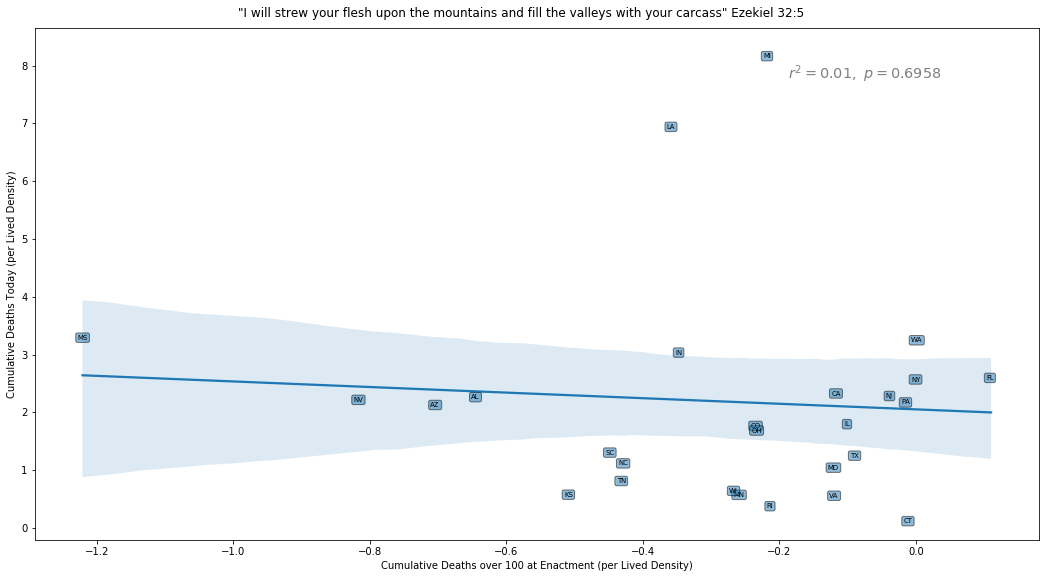

In [21]:

facebook_aspect_ratio = 1.91
show_x_y_labels('Deaths_Cumulative', get_threshold_lived_density_correlation,
                ' over 100 at Enactment (per Lived Density)', ' Today (per Lived Density)',
                aspect_ratio=facebook_aspect_ratio, log_scale=False)

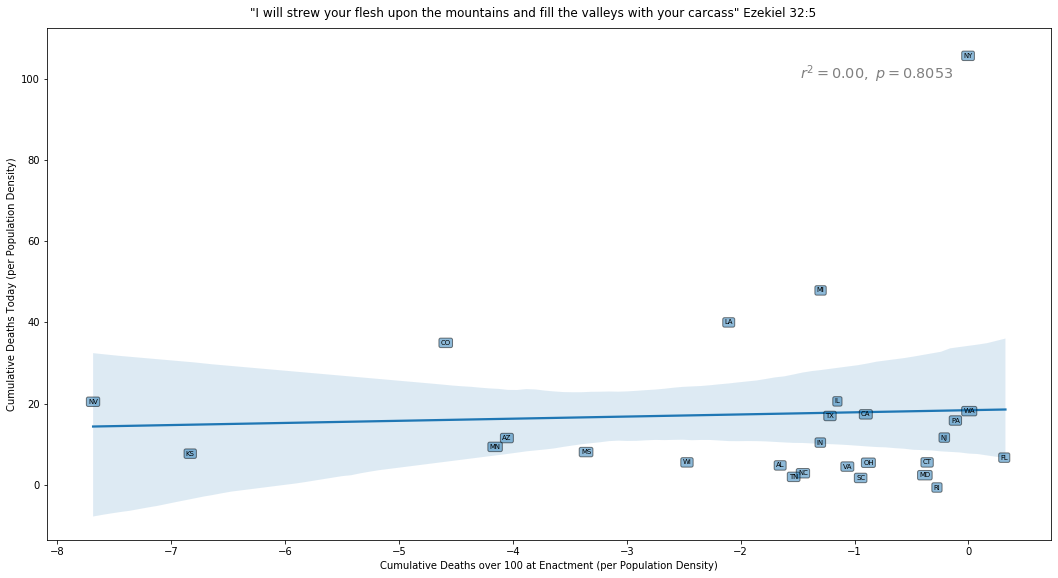

In [64]:

show_x_y_labels('Deaths_Cumulative', get_threshold_density_correlation,
                ' over 100 at Enactment (per Population Density)', ' Today (per Population Density)')

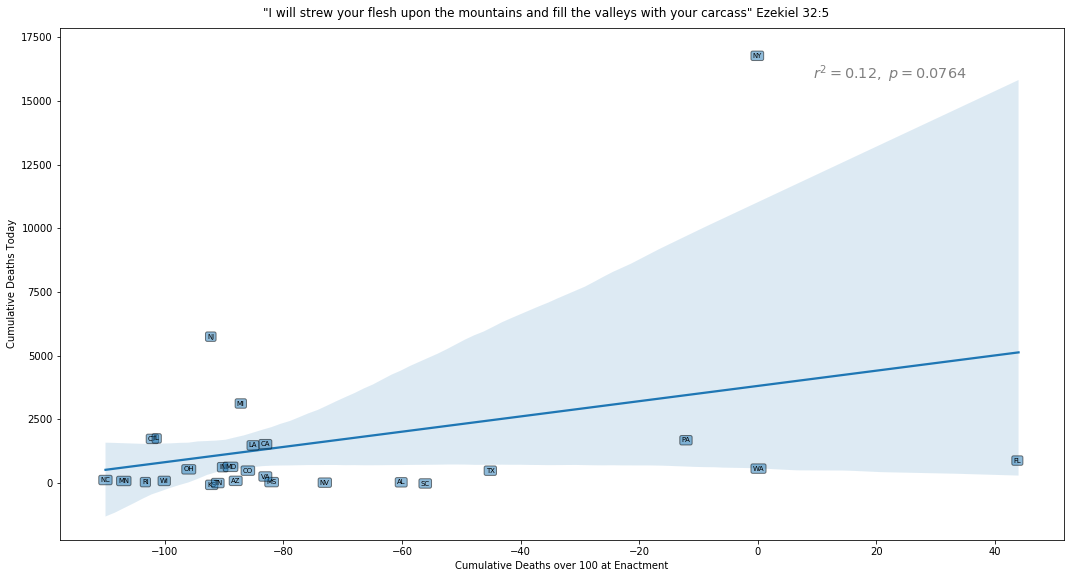

In [68]:

show_x_y_labels('Deaths_Cumulative', get_threshold_today_correlation, ' over 100 at Enactment', log_scale=False)

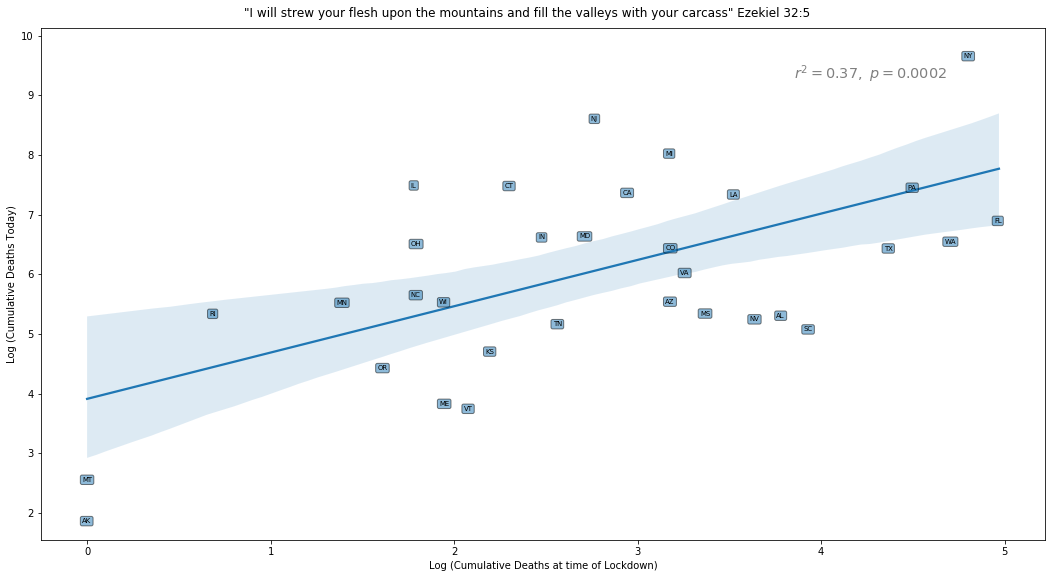

In [70]:

show_x_y_labels('Deaths_Cumulative', get_lockdown_today_correlation, log_scale=True)


----

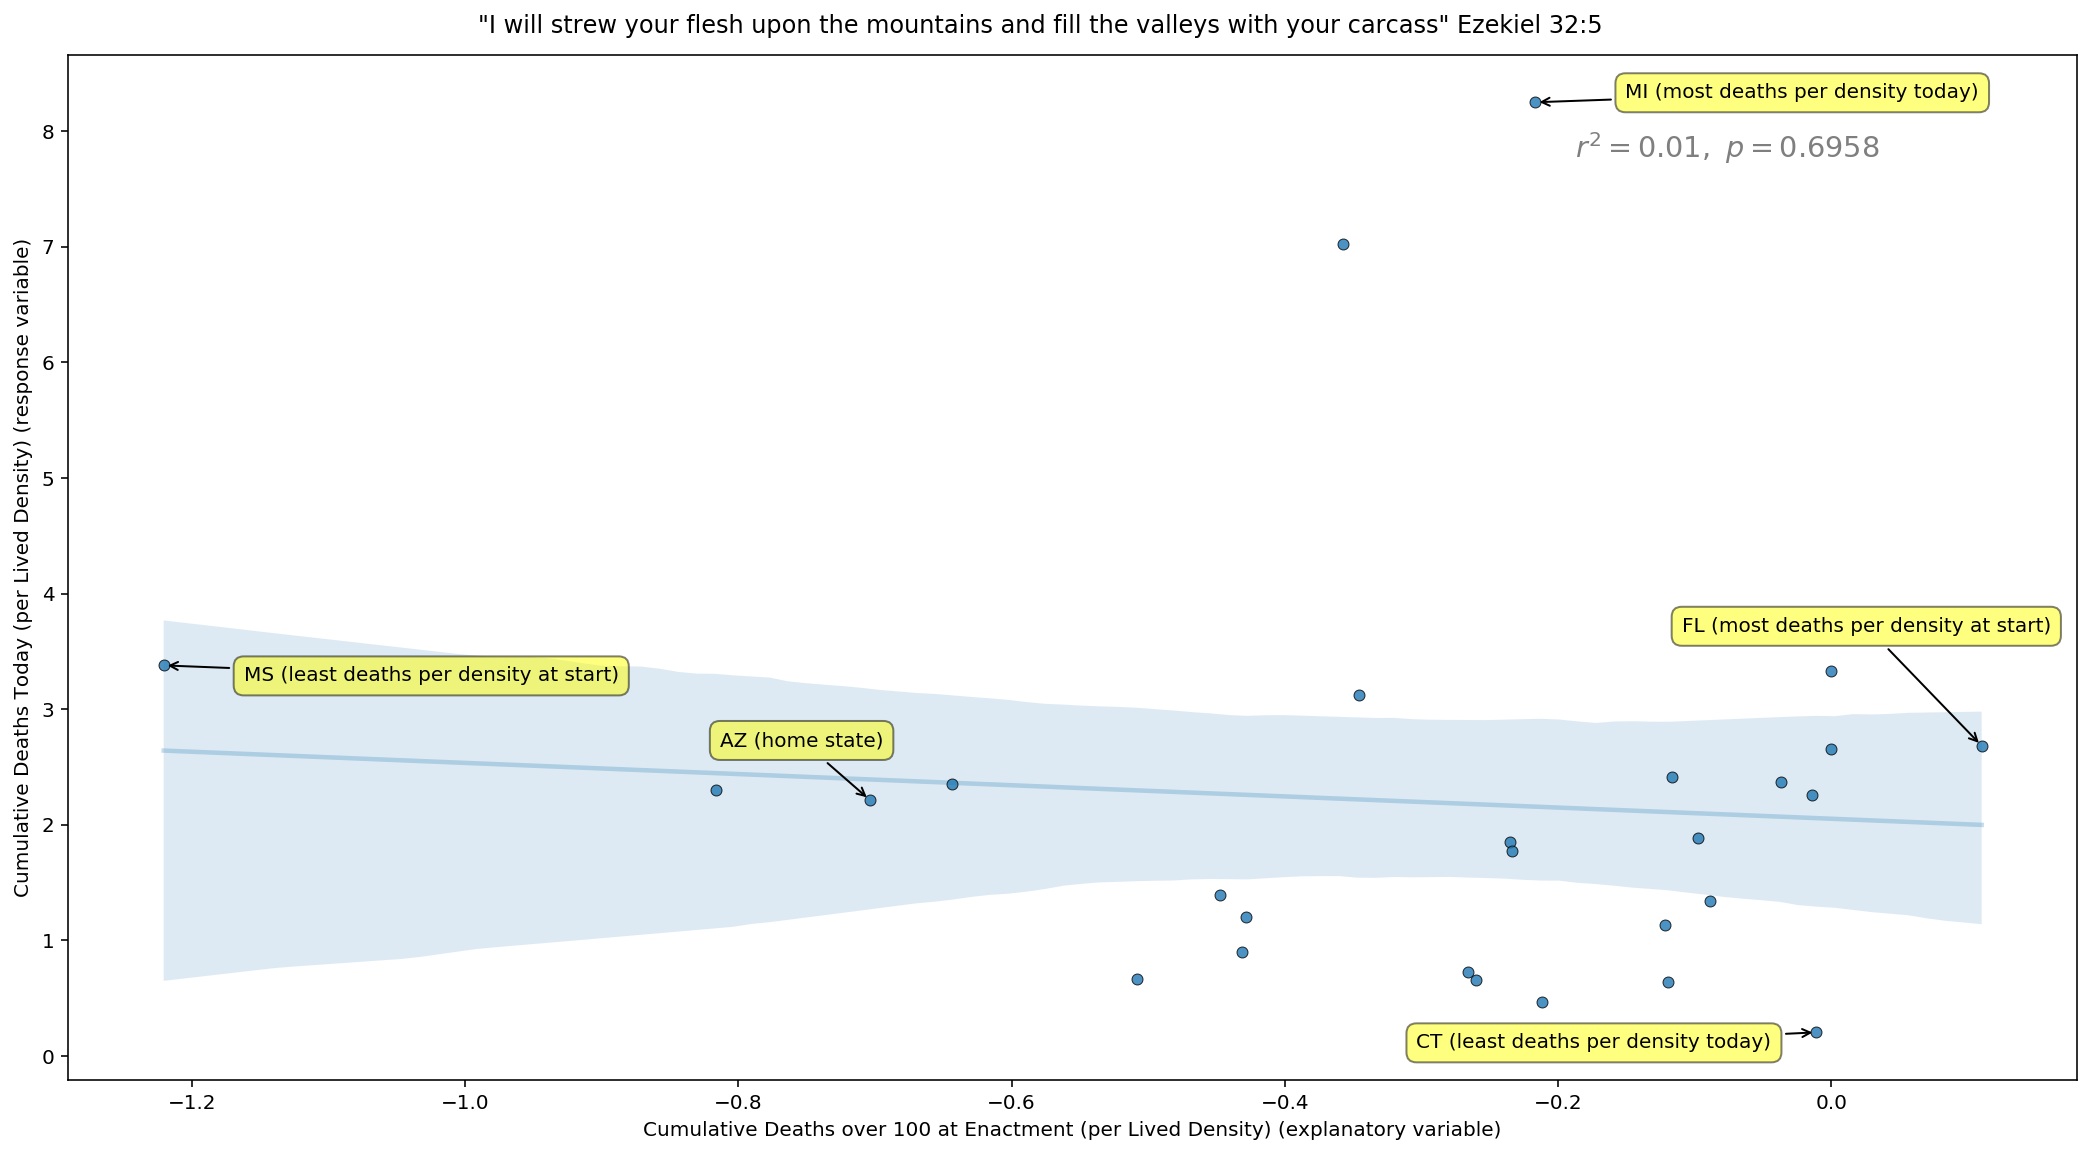

In [40]:

%run ../../load_magic/charts.py

column_name = 'Deaths_Cumulative'
xlabel_suffix = ' over 100 at Enactment (per Lived Density)'
ylabel_suffix = ' Today (per Lived Density)'
label_str = '{}{}'
xlabel_str = label_str.format(column_description_dict[column_name], xlabel_suffix)
ylabel_str = label_str.format(column_description_dict[column_name], ylabel_suffix)
x_list, y_list, label_list = get_threshold_lived_density_correlation(column_name)
df = pd.concat([pd.Series(x_list), pd.Series(y_list), pd.Series(label_list)],
               axis='columns').reset_index(level=0, inplace=False,
                                           drop=True).dropna(axis='index', how='any')
xname = 'most_deaths_at_start'
yname = 'most_deaths_today'
df.columns = [xname, yname, 'state_abbreviation']
df.set_index('state_abbreviation', drop=True, inplace=True)
title = '"I will strew your flesh upon the mountains and fill the valleys with your carcass" Ezekiel 32:5'
first_order_linear_scatterplot(df, xname, yname, xlabel_str, ylabel_str,
                               x_adj='deaths per density at start', y_adj='deaths per density today',
                               title=title, idx_reference='AZ', annot_reference='home state',
                               aspect_ratio=FACEBOOK_ASPECT_RATIO)


---
# Scrape the Data